In [196]:
import pandas as pd
import keras
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import random
import boto3
import matplotlib.image as mpimg
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import numpy as np
from PIL import Image

In [100]:
shutil.rmtree('test')
shutil.rmtree('train')
shutil.rmtree('val')

array = []
s3 = boto3.resource('s3')
bucket = s3.Bucket('vikram-data-dev')
for obj in bucket.objects.all():
    array.append(obj.key)

# Creating Train + Val + Test folders by class 
src = 'data'
classes_dir = ['/Parasitized/', '/Uninfected/']

val_ratio = 0.15
test_ratio = 0.05
allFileNames = array
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - val_ratio + test_ratio)), 
                                                           int(len(allFileNames)* (1 - test_ratio))])

train_FileNames = [name for name in train_FileNames.tolist()]
val_FileNames = [name for name in val_FileNames.tolist()]
test_FileNames = [name for name in test_FileNames.tolist()]

# Use if in notebook where new directories are needed
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')
os.mkdir('train/Parasitized')
os.mkdir('test/Parasitized')
os.mkdir('val/Parasitized')
os.mkdir('train/Uninfected')
os.mkdir('test/Uninfected')
os.mkdir('val/Uninfected')

for item in train_FileNames:
    destination = "train/{}".format(item)
    shutil.copy(item, destination)

for item in val_FileNames:
    destination = "val/{}".format(item)
    shutil.copy(item, destination)

for item in test_FileNames:
    destination = "test/{}".format(item)
    shutil.copy(item, destination)

# Example of Converting Image Format

In [ ]:
im1 = Image.open('train/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.jpg')

im1.save(r's3:/C100P61ThinF_IMG_20150918_144104_cell_162.png')

# Augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
x = img_to_array(img) )
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preproc',   save_prefix='test', save_format='jpeg'):
    i += 1
    if i > 20:
        break 

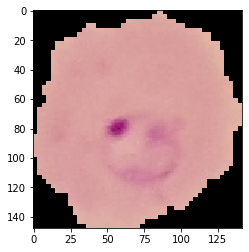

In [106]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
img = load_img('train/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')
plt.imshow(img)

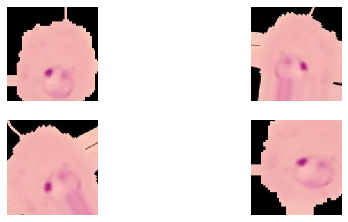

In [108]:
nrows = 4
ncols = 2

# Index for iterating
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 2)
pic_index += 8
next_positive_pic = [os.path.join('preproc', fname) for fname in preprocfiles[pic_index-4:pic_index]]

for i, img_path in enumerate(next_positive_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Main Model

In [311]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()

old = (150, 150, 3)
new = (400, 400, 3)

model.add(Conv2D(32, (3, 3), input_shape=old))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [312]:
batch_size = 12

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=(150, 150),  
#        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
val = test_datagen.flow_from_directory(
        'val',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')



Found 24777 images belonging to 2 classes.
Found 1377 images belonging to 2 classes.


In [313]:
model.fit_generator(
        train,
        steps_per_epoch=2000 // batch_size,
        epochs=30,
        validation_data=val,
        validation_steps=800 // batch_size)
model.save_weights('second_try.h5')  # always save your weights after training or during training

Epoch 1/30
166/166 [==============================] - 74s 448ms/step - loss: 0.6934 - accuracy: 0.5877 - precision_2: 0.5277 - recall_2: 0.6222 - auc: 0.5489 - val_loss: 0.6838 - val_accuracy: 0.5296 - val_precision_2: 0.5614 - val_recall_2: 0.7065 - val_auc: 0.6053
Epoch 2/30
166/166 [==============================] - 72s 433ms/step - loss: 0.5367 - accuracy: 0.7775 - precision_2: 0.5860 - recall_2: 0.7628 - auc: 0.6618 - val_loss: 0.0717 - val_accuracy: 0.9039 - val_precision_2: 0.6379 - val_recall_2: 0.8051 - val_auc: 0.7510
Epoch 3/30
166/166 [==============================] - 72s 434ms/step - loss: 0.4157 - accuracy: 0.8765 - precision_2: 0.6749 - recall_2: 0.8382 - auc: 0.8039 - val_loss: 0.2958 - val_accuracy: 0.8443 - val_precision_2: 0.6983 - val_recall_2: 0.8625 - val_auc: 0.8324
Epoch 4/30
166/166 [==============================] - 72s 435ms/step - loss: 0.3708 - accuracy: 0.8968 - precision_2: 0.7153 - recall_2: 0.8788 - auc: 0.8505 - val_loss: 0.1572 - val_accuracy: 0.9185

In [306]:
import tensorflow as tf
tf.keras.metrics.Precision()

In [278]:
len(val.classes)

1377

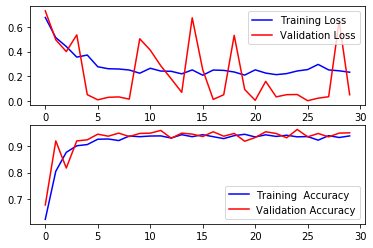

In [260]:
#After successful training, we will visualize its performance.

import matplotlib.pyplot as plt
#Plotting the training and validation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')
ax[0].legend()

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [ ]:
img = cv2.resize(cv2.imread('train/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'), (300, 300)).astype(np.float32)
plt.imshow(img1)

In [ ]:
img = img.reshape((1,) + img.shape)
out = model.predict(img)
print(out)

# VGG 16

In [319]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="train",target_size=(150,150))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="test", target_size=(150,150))

model = Sequential()
model.add(Conv2D(input_shape=(150,150,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

Found 24777 images belonging to 2 classes.
Found 1378 images belonging to 2 classes.


In [320]:
from keras.optimizers import Adam
opt = Adam(lr=0.002)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy,metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [321]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=0, mode='auto')
hist = model.fit_generator(steps_per_epoch=15,generator=traindata, validation_data= testdata, validation_steps=10,epochs=12,callbacks=[checkpoint,early])

Epoch 1/12
15/15 [==============================] - 165s 11s/step - loss: 54354.5460 - accuracy: 0.4750 - precision_4: 0.5064 - recall_4: 0.5064 - auc_2: 0.4918 - val_loss: 0.6747 - val_accuracy: 0.5344 - val_precision_4: 0.4874 - val_recall_4: 0.4874 - val_auc_2: 0.4763
Epoch 2/12


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_precision_4,val_recall_4,val_auc_2,loss,accuracy,precision_4,recall_4,auc_2
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


15/15 [==============================] - 164s 11s/step - loss: 0.7761 - accuracy: 0.5042 - precision_4: 0.5003 - recall_4: 0.5003 - auc_2: 0.4793 - val_loss: 0.6979 - val_accuracy: 0.5031 - val_precision_4: 0.5007 - val_recall_4: 0.5007 - val_auc_2: 0.4843
Epoch 3/12
15/15 [==============================] - 164s 11s/step - loss: 0.6894 - accuracy: 0.5250 - precision_4: 0.5005 - recall_4: 0.5005 - auc_2: 0.4905 - val_loss: 0.7758 - val_accuracy: 0.4938 - val_precision_4: 0.5045 - val_recall_4: 0.5045 - val_auc_2: 0.4952
Epoch 4/12
15/15 [==============================] - 165s 11s/step - loss: 0.7031 - accuracy: 0.4917 - precision_4: 0.5042 - recall_4: 0.5042 - auc_2: 0.4971 - val_loss: 0.6970 - val_accuracy: 0.5031 - val_precision_4: 0.5033 - val_recall_4: 0.5033 - val_auc_2: 0.4983
Epoch 5/12
15/15 [==============================] - 162s 11s/step - loss: 0.6956 - accuracy: 0.5125 - precision_4: 0.5026 - recall_4: 0.5026 - auc_2: 0.4989 - val_loss: 0.6935 - val_accuracy: 0.4828 - val_pr

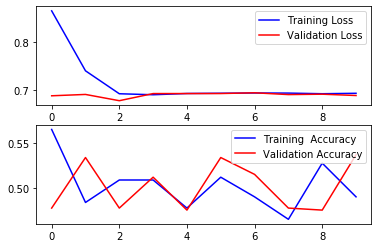

In [214]:
import matplotlib.pyplot as plt
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(hist.history['loss'],color='b',label='Training Loss')
ax[0].plot(hist.history['val_loss'],color='r',label='Validation Loss')
ax[0].legend()


#Plotting the training accuracy and validation accuracy
ax[1].plot(hist.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(hist.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()


# Transfer Learning

In [323]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# load model without classifier layers
model = VGG19(include_top=False, input_shape=(300, 300, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(1, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0   